In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#insert the absolute path to your data and models folder here
DATA_PATH= "/content/drive/MyDrive/FANIYAN PROJECT/CODE/Saved models and Pickles

In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.7 MB/s 


In [ ]:
import pickle
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
import matplotlib.pyplot as plt
from random import randint

In [ ]:
augmented_images= pickle.load(open(DATA_PATH+"augmented_images.pkl", "rb"))
augmented_masks= pickle.load(open(DATA_PATH+"augmented_masks.pkl", "rb"))

X_val= pickle.load(open(DATA_PATH+"val_images.pkl", "rb"))
y_val= pickle.load(open(DATA_PATH+"val_masks.pkl", "rb"))

In [ ]:
#normalize data
#augmented_images= augmented_images/255
#augmented_masks= augmented_masks/255

In [ ]:
print("Unique values in the image masks are {}".format(np.unique(augmented_masks[1])))

Unique values in the image masks are [0 1 2]


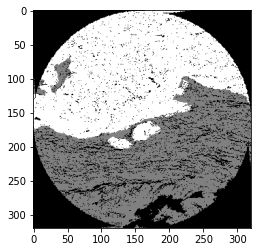

In [ ]:
plt.imshow(augmented_masks[0], cmap="gray")

In [ ]:
print("The shape of augmented_images is {}".format(augmented_images.shape))
print("The shape of augmented_masks is {}".format(augmented_masks.shape))

The shape of augmented_images is (840, 320, 320, 3)
The shape of augmented_masks is (840, 320, 320)


In [ ]:
X_train= augmented_images
y_train= augmented_masks
y_train= np.expand_dims(y_train, axis=3)
print("The shape of X_train is {}".format(X_train.shape))
print("The shape of y_train is {}".format(y_train.shape))

The shape of X_train is (840, 320, 320, 3)
The shape of y_train is (840, 320, 320, 1)


In [ ]:
y_val= np.expand_dims(y_val, axis=3)
print("The shape of X_val is {}".format(X_val.shape))
print("The shape of y_val is {}".format(y_val.shape))

The shape of X_val is (30, 320, 320, 3)
The shape of y_val is (30, 320, 320, 1)


In [ ]:
del augmented_images, augmented_masks #free space in ram

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [ ]:
BACKBONE= "resnet50"
preprocess_input= sm.get_preprocessing(BACKBONE)

In [ ]:
#convert the dependent arrays(masks) to categorical
n_classes=3
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

print(y_train_cat.shape)
print(y_val_cat.shape)


(840, 320, 320, 3)
(30, 320, 320, 3)


In [ ]:
X_train= preprocess_input(X_train)
X_val= preprocess_input(X_val)
#y_train= preprocess_input(y_train)
#y_val= preprocess_input(y_val)

In [ ]:
model = sm.Unet(BACKBONE, classes=3, activation='softmax', encoder_weights="imagenet")

metrics = [sm.metrics.IOUScore(threshold=0.5)]

model.compile(optimizer= "adam", loss= sm.losses.categorical_focal_dice_loss, metrics= metrics)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [ ]:
history= model.fit( x= X_train, y= y_train_cat,
                     batch_size=16,
                     epochs=100,
                     validation_data=(X_val, y_val_cat))

Epoch 1/100
53/53 [==============================] - 60s 802ms/step - loss: 0.4413 - iou_score: 0.4834 - val_loss: 1.7412 - val_iou_score: 0.1144
Epoch 2/100
53/53 [==============================] - 31s 585ms/step - loss: 0.3463 - iou_score: 0.5824 - val_loss: 1.5709 - val_iou_score: 0.1665
Epoch 3/100
53/53 [==============================] - 31s 588ms/step - loss: 0.3107 - iou_score: 0.6195 - val_loss: 0.5287 - val_iou_score: 0.4079
Epoch 4/100
53/53 [==============================] - 31s 591ms/step - loss: 0.2784 - iou_score: 0.6540 - val_loss: 0.9501 - val_iou_score: 0.3054
Epoch 5/100
53/53 [==============================] - 32s 595ms/step - loss: 0.2670 - iou_score: 0.6660 - val_loss: 0.4356 - val_iou_score: 0.5056
Epoch 6/100
53/53 [==============================] - 32s 600ms/step - loss: 0.2412 - iou_score: 0.6944 - val_loss: 0.5153 - val_iou_score: 0.4362
Epoch 7/100
53/53 [==============================] - 32s 604ms/step - loss: 0.2273 - iou_score: 0.7094 - val_loss: 0.2826 - 

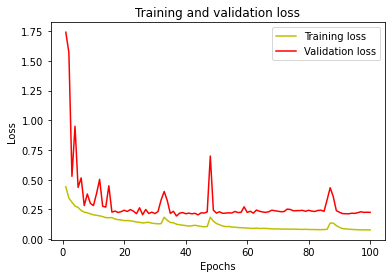

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

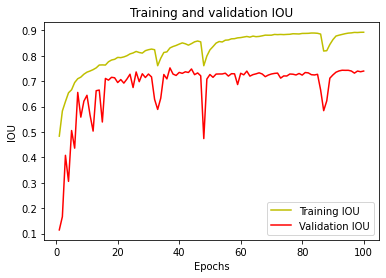

In [ ]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

Save model

In [ ]:
from tensorflow import keras
model.save(DATA_PATH+"resnet50")

#np.save('/content/drive/MyDrive/FANIYAN PROJECT/CODE/Saved models and Pickles/resnet50_history.npy',history.history)
pickle.dump(history.history, open(DATA_PATH+"resnet50_history.pkl", "wb"))


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FANIYAN PROJECT/CODE/Saved models and Pickles/resnet50/assets


Load model

In [ ]:
from tensorflow import keras
model = keras.models.load_model(DATA_PATH+"resnet50", compile=False)

#history=np.load('/content/drive/MyDrive/FANIYAN PROJECT/CODE/Saved models and Pickles/resnet50_history.npy',allow_pickle='TRUE').item()
history= pickle.load(open(DATA_PATH+"resnet50_history.pkl", "rb"))

# Visualize

testing using train data

In [ ]:
pred= model.predict(X_val) 
#pred= np.argmax(pred, axis=3) #convert categorical back to 1 dimension to make it easier to manipulate images 

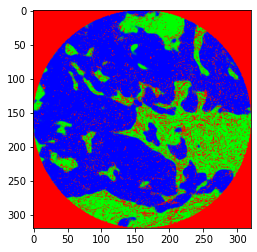

In [ ]:
p= 9
plt.imshow(pred[p])

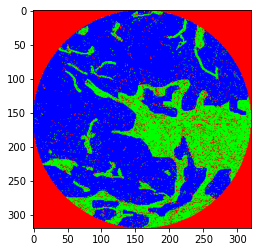

In [ ]:
plt.imshow(y_val_cat[p])

testing using test data

In [ ]:
test_images= pickle.load(open(DATA_PATH+"test_images.pkl", "rb"))
test_masks= pickle.load(open(DATA_PATH+"test_masks.pkl", "rb"))

In [ ]:
test_images= preprocess_input(test_images)

In [ ]:
test_pred= model.predict(test_images)
test_pred_dim1=  np.argmax(test_pred, axis=3) #change image dimensions back
print(test_pred.shape, test_pred_dim1.shape)

(30, 320, 320, 3) (30, 320, 320)


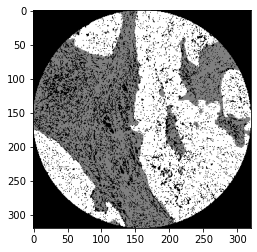

In [ ]:
from random import randint
p= 8#randint(0, 19)
plt.imshow(test_pred_dim1[p], cmap= "gray")
#plt.imshow(test_pred[p][:,:,0])#, cmap= "gray")

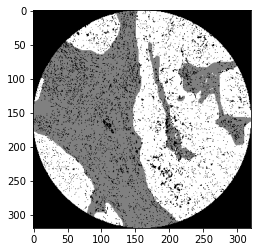

In [ ]:
plt.imshow(test_masks[p], cmap="gray")